In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import timm

import os

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.transforms import RandomRotation, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# Constants

EPOCHS = 10
IMG_SIZE = (128, 128)
FILTER_SIZE = 3
BATCH_SIZE = 4
LEARNING_RATE = 0.001
PATIENCE = 50
SEED = 12

NUM_CLASSES = 4
NUM_CHANNELS = 3

TEST_TRAIN_SPLIT = 0.2

NUM_FEATURES = 768

# File Paths
ROOT_PATH = "/content/drive/MyDrive/Dogs"
BD_PATH = "/content/drive/MyDrive/Dogs/Bacterial_dermatosis"
FI_PATH = "/content/drive/MyDrive/Dogs/Fungal_infections"
H_PATH = "/content/drive/MyDrive/Dogs/Healthy"
H_A_D_PATH = "/content/drive/MyDrive/Dogs/Hypersensitivity_allergic_dermatosis"

# Create model
model = timm.create_model('vit_base_patch14_reg4_dinov2.lvd142m', pretrained=True)

# Transformation pipeline
transform_image = T.Compose([
    T.ToTensor(),
    T.Resize(560),
    T.CenterCrop(518),
    RandomRotation(degrees=30),  # rotation +- 30 deg
    RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.1, scale=(0.9, 1.1)),
                # 10% Tolerance Range
    RandomHorizontalFlip(),  # Horizontal flip
    RandomVerticalFlip(),  # Vertical flip
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisation
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Move the model to the device

dataset = ImageFolder(root=ROOT_PATH, transform=transform_image)
print("Class-to-Label Mapping:", dataset.class_to_idx)
labels = dataset.class_to_idx

test_size = int(TEST_TRAIN_SPLIT * len(dataset))
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Freeze the existing model layers
for param in model.parameters():
    param.requires_grad = False

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Final classification head
num_features = NUM_FEATURES
num_classes = NUM_CLASSES

model.head = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes),
)

model.head = model.head.to(device)

trainable_params = [p for p in model.head.parameters() if p.requires_grad]
print(f"Trainable parameters count: {sum(p.numel() for p in trainable_params)}")

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.head.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(pred, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

        if batch // 16 == 0: # Large Batches
          print(f"Epoch {epoch+1}, Batch {BATCH_SIZE}, Loss: {loss.item():>7f}")

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Test phase
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            test_running_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()

    test_epoch_loss = test_running_loss / len(test_dataloader)
    test_epoch_accuracy = 100 * test_correct / test_total
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
          f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "model_state_dict.pth")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Class-to-Label Mapping: {'Bacterial_dermatosis': 0, 'Fungal_infections': 1, 'Healthy': 2, 'Hypersensitivity_allergic_dermatosis': 3}
Trainable parameters count: 197892
Epoch 1, Batch 4, Loss: 1.569172
Epoch 1, Batch 4, Loss: 1.485894
Epoch 1, Batch 4, Loss: 1.565304
Epoch 1, Batch 4, Loss: 1.515252
Epoch 1, Batch 4, Loss: 1.094621
Epoch 1, Batch 4, Loss: 1.621174
Epoch 1, Batch 4, Loss: 1.447785
Epoch 1, Batch 4, Loss: 1.283347
Epoch 1, Batch 4, Loss: 1.087068
Epoch 1, Batch 4, Loss: 1.132931
Epoch 1, Batch 4, Loss: 1.184645
Epoch 1, Batch 4, Loss: 1.219771
Epoch 1, Batch 4, Loss: 1.296418
Epoch 1, Batch 4, Loss: 0.907500
Epoch 1, Batch 4, Loss: 1.161698
Epoch 1, Batch 4, Loss: 1.253190
Epoch 1: Train Loss: 1.1643, Train Accuracy: 47.16%, Test Loss: 0.9611, Test Accuracy: 60.23%
Epoch 2, Batch 4, Loss: 0.916642
Epoch 2, Batch 4, Loss: 0.702348
Epoch 2, Batch 4, Loss: 0.791640
Epoch 2, Batch 4, Loss: 0.975007
Epoch 2, Batch 4, Loss: 0.953215
Epoch 2, Batch 4, Loss: 1.116580
Epoch 2, Bat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


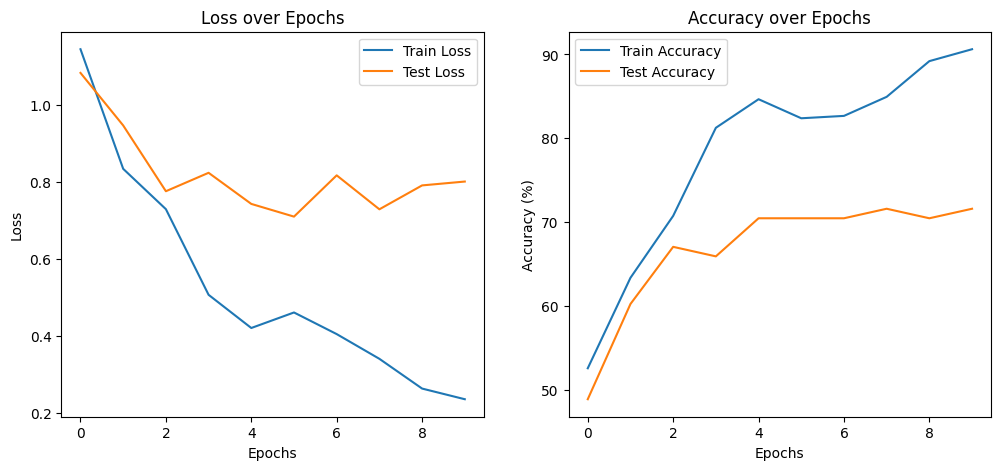

In [ ]:
# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()
